# Quarante huit heures plus tard

Un modèle de propagation d'un virus en python

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from scipy.spatial import cKDTree
from ipywidgets import interactive



%matplotlib inline

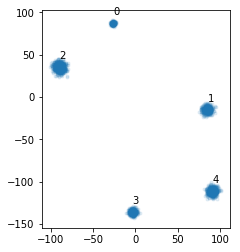

In [186]:
n_cities = 5
max_pop = 1000

populations = np.random.choice(max_pop, n_cities)
total_pop = populations.sum()

cities = pd.DataFrame(np.zeros((n_cities, 3)),
                      columns=['population', 'lat', 'long'])

cities['population'] = populations

people = pd.DataFrame(np.zeros((total_pop, 3)),
                      columns=('state', 'lat', 'long'))

people['state'] = 'sane'

city_centers = np.random.normal(scale=50, size=(n_cities, 2))
cities[['lat', 'long']] = city_centers

current = 0
for idx, city in cities.iterrows():
    pop = int(city['population'])
    positions = np.random.normal(scale=pop/200, size=(pop, 2))
    
    people.loc[current: pop+current-1,
               ['lat', 'long']] = positions + city[['lat', 'long']].values
    
    current = pop + current



fig, ax = plt.subplots()

ax.plot(people.lat, people.long, '.', alpha=0.1)

for idx, city in cities.iterrows():
    ax.text(city.lat, city.long+10, idx)
    
ax.set_aspect('equal')
xlim = ax.get_xlim()
ylim = ax.get_ylim()


In [187]:
people.head()

,state,lat,long
0,sane,-24.847419,85.157662
1,sane,-24.476282,86.777988
2,sane,-27.658798,88.025835
3,sane,-26.254498,85.270726
4,sane,-25.486035,87.919124


In [188]:
cities

,population,lat,long
0,255,-26.451690,87.022541
1,604,85.110965,-15.036346
2,764,-89.580049,35.154245
3,485,-3.268245,-136.196945
4,635,90.887929,-111.448929


In [189]:

def move(people, speed):
    displacement = np.random.normal(scale=speed, 
                                    size=(people.shape[0], 2))
    people[['lat', 'long']] += displacement
    

def infect(people, rate, critical_dist):
    tree = cKDTree(people[['lat', 'long']])
    sicks = people[people['state'] == 'sick']
    contacts = tree.query_ball_point(sicks[['lat', 'long']], critical_dist)
    contacts = np.array(
        [[i, c] for i, encounters in enumerate(contacts) 
         for c in encounters if len(encounters) > 1])
    if not len(contacts):
        return None
    dices = np.random.random(contacts.shape[0])
    infected = contacts[dices < rate][:, 1]
    people.loc[infected, 'state'] = 'sick'
    return contacts

def register(people, history=None):

    if history is None:
        history = people.copy()
        history['t'] = 0
        return history
    prev_t = history['t'].max()
    new_t = prev_t + 1
    people['t'] = new_t
    history = history.append(people, ignore_index=False)
    return history
    

In [191]:
people.loc[0:10, 'state'] = 'sick'
num_t = 15

def time_step(people, history, speed, 
              rate, critical_distance):
    move(people, speed)
    infect(people, rate, critical_distance)
    history = register(people, history)
    print(f"Number of sick persons: {(people.state == 'sick').sum()}")
    return history
    
def run_simulation(num_t, people, **kwargs):
    history = register(people, None)
    for t in range(num_t):
        history = time_step(people, history, **kwargs)
    return history

parameters = {"speed": 2,
              "rate": 0.3,
              "critical_distance": 1}

history = run_simulation(num_t, people, **parameters)



Number of sick persons: 22
Number of sick persons: 34
Number of sick persons: 42
Number of sick persons: 57
Number of sick persons: 68
Number of sick persons: 77
Number of sick persons: 91
Number of sick persons: 103
Number of sick persons: 112
Number of sick persons: 117
Number of sick persons: 124
Number of sick persons: 128
Number of sick persons: 135
Number of sick persons: 141
Number of sick persons: 148


In [192]:

def plot_progression(t):
    people = history[history['t'] == t]
    ax = plt.gca()
    for state in ['sane', 'sick']:
        group = people[people['state'] == state]
        ax.plot(group.lat, group.long, '.', ms=1, alpha=0.8) 
        
    ax.set(xlim=xlim,
           ylim=ylim,
           aspect='equal')

    plt.show()
    
num_t = history.t.max()

interactive_plot = interactive(plot_progression, t=(0, num_t), ax=ax)
interactive_plot.children[0].value=0
interactive_plot


interactive(children=(IntSlider(value=0, description='t', max=15), Output()), _dom_classes=('widget-interact',…

In [194]:
people.shape

(2743, 4)

# Real world data

In [170]:
%%bash
curl https://www.google.org/flutrends/about/data/flu/fr/data.txt > data_sample/ggle_data.csv
head -n 12 data_sample/ggle_data.csv

Google Flu Trends - France
Copyright 2015 Google Inc.

Exported data may be used for any purpose, subject to the Google Terms of Service (http://www.google.com/accounts/TOS?hl=en_US).
If you choose to use the data, please attribute it to Google as follows: "Data Source: Google Flu Trends (http://www.google.org/flutrends)".

Each week begins on the Sunday (Pacific Time) indicated for the row.
Data for the current week will be updated each day until Saturday (Pacific Time).
Note: To open these files in a spreadsheet application, we recommend you save each text file as a CSV spreadsheet.
For more information, please visit http://www.google.org/flutrends

Date,France,Alsace,Aquitaine,Auvergne,Burgundy,Brittany,Centre,Champagne-Ardenne,Franche-Comte,Ile-de-France,Languedoc-Roussillon,Lorraine,Midi-Pyrenees,Nord-Pas-de-Calais,Normandy - Lower,Normandy - Upper,Pays de la Loire,Picardie,Poitou-Charentes,Provence-Alpes-Cote d'Azur,Rhône-Alpes


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 42625    0 42625    0     0   225k      0 --:--:-- --:--:-- --:--:--  244k


In [172]:
ggle = pd.read_csv('data_sample/ggle_data.txt',
                   skiprows=10, index_col=0)
# Note that you can magically do 
# ggle = pd.read_csv('https://www.google.org/flutrends/about/data/flu/fr/data.txt',
#                    skiprows=10, index_col=0)

ggle.index = pd.to_datetime(ggle.index, format='%Y-%m-%d')
ggle.head()

,France,Alsace,Aquitaine,Auvergne,Burgundy,Brittany,Centre,Champagne-Ardenne,Franche-Comte,Ile-de-France,...,Lorraine,Midi-Pyrenees,Nord-Pas-de-Calais,Normandy - Lower,Normandy - Upper,Pays de la Loire,Picardie,Poitou-Charentes,Provence-Alpes-Cote d'Azur,Rhône-Alpes
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-28,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-05,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-12,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-19,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-26,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0


[Text(0,0.5,'Number of ')]

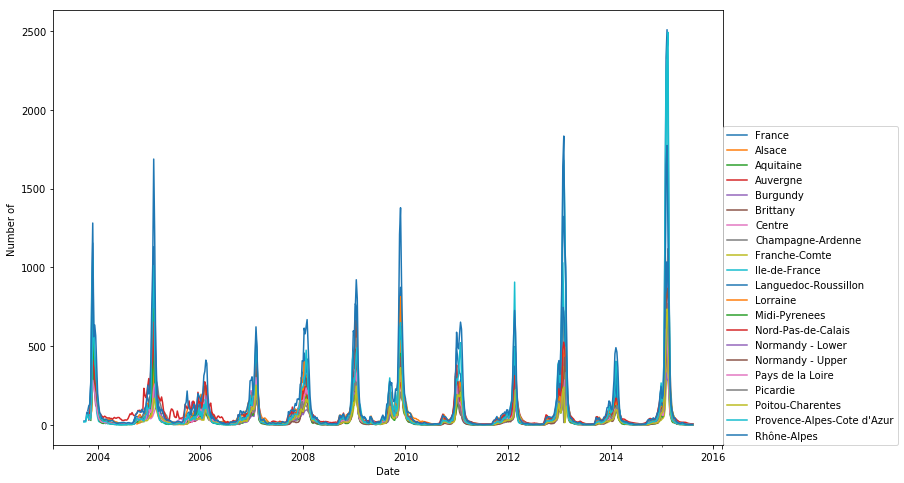

In [173]:
ax = ggle.plot()
ax.legend(loc=(1, 0))
fig = ax.get_figure()
fig.set_size_inches(12, 8)
ax.set(ylabel='Number of ')

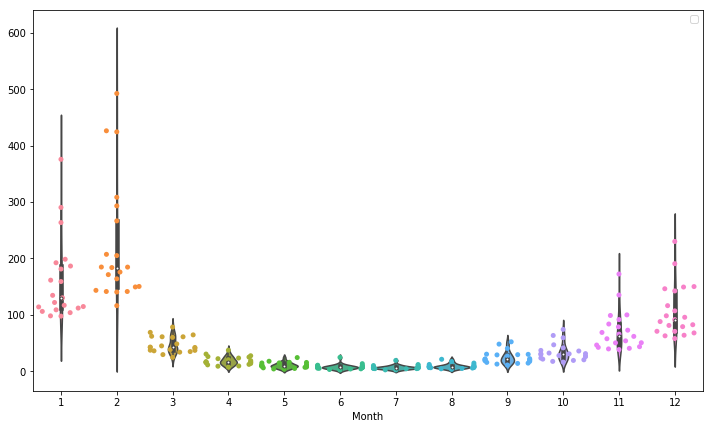

In [177]:
# I actually found a bug preparing this
# https://github.com/mwaskom/seaborn/issues/1438

monthly = ggle.groupby(ggle.index.month).mean()

fig, ax = plt.subplots()
sns.swarmplot(data=monthly.T, ax=ax)
sns.violinplot(data=monthly.T, ax=ax)
ax.set(xlabel='Month')
ax.legend(labels=[])
fig.set_size_inches(12, 7)

In [181]:
ggle.head()

,France,Alsace,Aquitaine,Auvergne,Burgundy,Brittany,Centre,Champagne-Ardenne,Franche-Comte,Ile-de-France,...,Lorraine,Midi-Pyrenees,Nord-Pas-de-Calais,Normandy - Lower,Normandy - Upper,Pays de la Loire,Picardie,Poitou-Charentes,Provence-Alpes-Cote d'Azur,Rhône-Alpes
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-28,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-05,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-12,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-19,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-10-26,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0


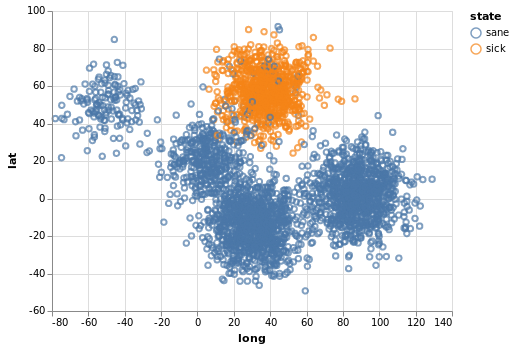

In [185]:
import altair as alt
from vega_datasets import data

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')



alt.Chart(people).mark_point().encode(
    x='long',
    y='lat',
    color='state'
)


In [183]:
history

,state,lat,long,t
0,sick,59.369633,41.341818,0
1,sick,60.938258,34.153104,0
2,sick,73.255948,52.560536,0
3,sick,64.417655,32.564007,0
4,sick,39.209020,36.399374,0
5,sick,66.178154,30.466129,0
6,sick,54.268310,44.904449,0
7,sick,68.094424,26.610581,0
8,sick,58.732379,40.371013,0
9,sick,38.444056,33.742466,0
